- Физическое определение средней скорости:

$$Vmean = \frac{(S_1+⋯+S_N)}{(t_1+⋯+t_N )}=\frac{(S_1+⋯+S_N)}{(\frac{S_1}{V_1} +⋯+\frac{S_N}{V_N} )}=\frac{(Весь путь)}{(Всё время)}$$

- 	Если все проходят одинаковое расстояние S с разными скоростями:

$$Vmean = \frac{(S+⋯+S)}{(\frac{S}{V_1} +⋯+\frac{S_N}{V_N})}=\frac{N}{(\frac{1}{V_1} +⋯+\frac{1}{V_N})}$$

- Последняя формула и есть среднее гармоническое

**Пример**

Машина едет первые 500 м со скоростью 20 м/с, а вторые 500 м – со скоростью 100 м/с. Тогда средняя скорость движения равна:
$$Vmean=\frac{(500+500)}{(\frac{500}{20}+\frac{500}{100})}=\frac{1000}{30} = \frac{2}{(\frac{1}{20}+\frac{1}{100})}=33.3 м/с$$
Это значит, что если машина будет двигаться с постоянной скоростью в 33.3 м/с, то она преодолеет всё расстояние (1000 м) за 30 сек.


Возьмём среднее арифметическое скоростей:
$$V'=\frac{(20+100)}{2} = 60 м/с$$
What does it mean? I don’t know.


**В итоге, в качестве оценки средней скорости будем рассматривать среднее гармоническое моментных (текущих) скоростей**

### Подгрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st

### Подгрузим данные

df0 = speeds_msk_spb.csv

- city - город (moscow, spb);
- d - дата-время, когда было зарегистрировано событие (по мск);
- speed - текущая скоросить км/ч;
- edge_id - идентификатор ребра, по которому в настоящий момент движется водитель.

In [2]:
df0 = pd.read_csv('speeds_msk_spb.csv')
len(df0)

100000

df1 = graph_msk_spb.csv

- city - город (moscow, spb)
- edge_id - идентификатор ребра
- length - длина ребра в метрах
- width - ширина ребра в метрах
- lanes - количество автомобильных полос на ребре
- def_speed - максимально допустимая скорость на ребре в км/ч

In [3]:
df1 = pd.read_csv('graph_msk_spb.csv')
len(df1)

3642676

**Дополним таблицу df0 столбцами из df1 по ключу edge_id**

In [4]:
dff = pd.merge(df0,df1, how = 'left', on = 'edge_id' )
dff.dropna(inplace = True) # Удаляем пропуски в данных, так как мы будем сравнивать скорости при совпадающих дорожных параметрах
dff.index = list(range(len(dff)))

In [5]:
# Посмотрим, как распределены данные длины ребра
dff['length'].mean(), dff['length'].median(), dff['length'].max(), dff['length'].min()

(234.21380641419242, 105.0, 12416.0, 2.0)

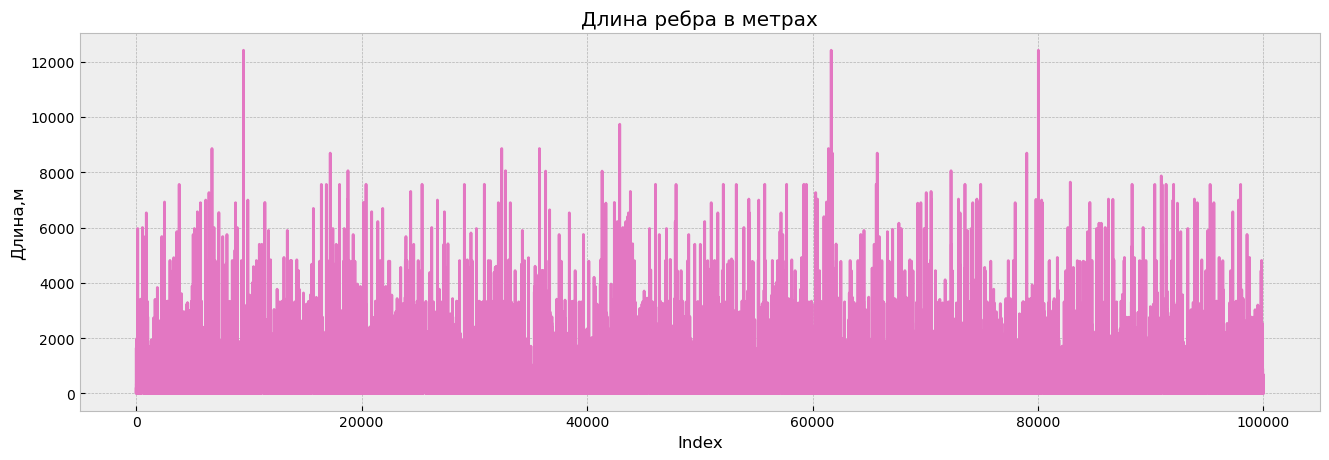

In [6]:
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Длина,м', dpi=100, style = 'bmh'):
    with plt.style.context(style):
        plt.figure(figsize=(16,5), dpi=dpi)
        plt.plot(x, y, color='tab:pink')
        plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
        plt.show()
        
plot_df(dff['length'], x=dff.index, y=dff['length'], title='Длина ребра в метрах')  

Корректнее сравнивать средние скорости в разных городах по одинаковым дорожным параметрам:

In [7]:
%%time
# Заводим сетку дорожных параметров
def_speed = dff['def_speed'].unique()
city = dff['city_x'].unique()
lanes = dff['lanes'].unique()
width = dff['width'].unique()

# Сетка параметров length выбрана, исходя из идеи, что интервалы, которые попадают, например, в [1,10) имеют ОДИНАКОВУЮ длину.
# Нельзя переребирать по уникальному ключу ряд длины ребра, потому что в Москве и Санкт-Петербурге разные расстояния ребер, может не оказаться совпадений
length = list(range(2,12000,10)) 

# Создаем DataFrame, в который будут помещены результаты
TestModels = pd.DataFrame()
tmp = {} 

# Перебираем нашу сетку, ищем совпадающие между городами параметры (те, что не совпадут, удалим) и считаем среднее гармоническое
for t in def_speed:
    for j in width:
        for i in lanes:
            for m in range(1,len(length)):
                d1 = dff[(dff['city_x'] == city[0]) & (dff['def_speed'] == t) & (dff['lanes'] == i) &
                         (dff['length'] >= length[m-1]) & (dff['length'] < length[m]) &
                             (dff['width'] == j) ]
                
                d2 = dff[(dff['city_x'] == city[1]) & (dff['def_speed'] == t) & (dff['lanes'] == i) &
                         (dff['length'] >= length[m-1]) & (dff['length'] < length[m]) &
                             (dff['width'] == j) ]

                tmp['lanes'] = i
                tmp['width'] = j 
                tmp['def_speed'] = t
                tmp['length'] = [length[m-1],length[m]]
                
                try:
                    tmp['harmonic_mean_msk'] = st.harmonic_mean(d1['speed'])

                    tmp['harmonic_mean_spb'] = st.harmonic_mean(d2['speed'])
                    
                except:
                    continue 
                
                TestModels = TestModels.append([tmp])

# TestModels.set_index(list(range(len())),inplace = True)
TestModels.dropna(inplace = True)
TestModels.index = list(range(len(TestModels)))

Wall time: 38min 31s


**Получаем DF, в котором посчитаны гармонические средние скорости при совпадающих дорожных параметрах. Теперь мы можем сравнивать средние скорости между городами**

In [8]:
TestModels

,lanes,width,def_speed,length,harmonic_mean_msk,harmonic_mean_spb
0,5.0,18.0,60.0,"[2, 12]",12.931351,37.440000
1,5.0,18.0,60.0,"[12, 22]",14.529049,8.209017
2,5.0,18.0,60.0,"[22, 32]",12.266712,8.249771
3,5.0,18.0,60.0,"[32, 42]",12.682024,17.805988
4,5.0,18.0,60.0,"[42, 52]",11.642903,14.919574
...,...,...,...,...,...,...
515,4.0,15.0,90.0,"[422, 432]",65.254944,95.186942
516,4.0,15.0,90.0,"[442, 452]",97.993266,63.444649
517,4.0,15.0,90.0,"[452, 462]",8.171985,13.259026
518,4.0,15.0,90.0,"[482, 492]",92.321065,80.760321


**Для того, чтобы определить, как средние скорости в Москве и Санкт-Петербурге отличаются, посчитаем количество точек при совпадающих дорожных параметрах, в которых, например, в Москве средняя скорость выше**

In [9]:
TestModels['diff'] = TestModels['harmonic_mean_msk'] - TestModels['harmonic_mean_spb']

In [18]:
print(f'В {TestModels[TestModels.columns[-1]][TestModels[TestModels.columns[-1]] > 0].count()} случаях из {len(TestModels)} средняя скорость в Москве выше, чем в Санкт-Петербурге, что составляет {round(TestModels[TestModels.columns[-1]][TestModels[TestModels.columns[-1]] > 0].count()/len(TestModels),2)*100} % от всех случаев')

В 235 случаях из 520 средняя скорость в Москве выше, чем в Санкт-Петербурге, что составляет 45.0 % от всех случаев


Значит, в Санкт-Петербурге в большинстве случаев (55% из 520) средняя скорость выше, чем в Москве

Также можем получить "грубую" оценку средних скоростей городов, взяв среднее арифметическое от средних гармонических:

In [11]:
print(f'Усредненные гармонические скорости в Москве: {round(TestModels[TestModels.columns[4]].mean(),2)} км/ч, в Санкт-Петербурге: {round(TestModels[TestModels.columns[5]].mean(),2)} км/ч')

Усредненные гармонические скорости в Москве: 33.05 км/ч, в Санкт-Петербурге: 39.15 км/ч


**Другое решение с точки зрения физического определения средней скорости при прочих равных условиях**

In [12]:
dff['TIME,hours'] = dff['length']/1000/dff['speed']

In [13]:
df_msc = dff[dff['city_x']== 'moscow']

In [14]:
df_spb = dff[dff['city_x']== 'spb']

**Средняя скорость в Москве**

In [15]:
print(f'{round(df_msc[df_msc.columns[5]].sum()/(1000*df_msc[df_msc.columns[-1]].sum()),2)} км/ч')

20.46 км/ч


**Средняя скорость в Санкт-Петербурге**

In [16]:
print(f'{round(df_spb[df_spb.columns[5]].sum()/(1000*df_spb[df_spb.columns[-1]].sum()),2)} км/ч')

23.45 км/ч
